# 02 - Data Preprocessing

**Goal:** Walk through preprocessing steps interactively and prepare the data for modeling.

This notebook covers:
1. Loading raw data from GEO files
2. Applying gene filtering step-by-step, visualizing effect on dimensions
3. Applying cell filtering with quality thresholds
4. Verifying normalization (data is already log2(TPM+1) transformed)
5. Creating UMAP/PCA visualizations for quality assessment
6. Saving final processed AnnData object

---

**Dataset:** GSE120575 (Sade-Feldman et al., 2018)  
**Source:** Tumor-infiltrating CD45+ immune cells from melanoma patients  
**Output:** `data/processed/melanoma_adata.h5ad` ready for XGBoost modeling


## Setup


In [1]:
# Standard imports
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad

# Add src directory to path for importing our modules
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Import our data loading and preprocessing functions
from data_loading import (
    load_melanoma_data,
    DEFAULT_EXPR_PATH,
    DEFAULT_PATIENT_PATH,
)
from preprocessing import (
    filter_genes,
    filter_cells,
    compute_qc_metrics,
    normalize_expression,
    add_response_labels,
    save_preprocessed_data,
    DEFAULT_OUTPUT_PATH,
)

# Set up paths
EXPR_PATH = PROJECT_ROOT / DEFAULT_EXPR_PATH
PATIENT_PATH = PROJECT_ROOT / DEFAULT_PATIENT_PATH
OUTPUT_PATH = PROJECT_ROOT / DEFAULT_OUTPUT_PATH
FIGURES_DIR = PROJECT_ROOT / "results" / "figures"

# Ensure directories exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 11

# Scanpy settings
sc.settings.verbosity = 2  # Moderate verbosity
sc.settings.set_figure_params(dpi=100, facecolor='white')

print(f"Project root: {PROJECT_ROOT}")
print(f"Expression file: {EXPR_PATH}")
print(f"Patient file: {PATIENT_PATH}")
print(f"Output will be saved to: {OUTPUT_PATH}")


Project root: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml
Expression file: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/raw/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz
Patient file: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/raw/GSE120575_patient_ID_single_cells.txt.gz
Output will be saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad


---
## 1. Load Raw Data

Load the expression matrix and patient metadata into an AnnData object.

**Key facts about the raw data:**
- ~16,290 cells from 48 patient samples
- ~55,737 genes
- Expression values are already **log2(TPM+1)** transformed
- Highly sparse (~95.7% zeros)


In [2]:
# Load raw data into AnnData object
print("Loading raw data (this may take a minute)...")
print("=" * 60)
adata_raw = load_melanoma_data(EXPR_PATH, PATIENT_PATH)


Loading raw data (this may take a minute)...
Loading expression matrix...


  Dropping 1 unnamed columns: ['Unnamed: 0']


  Dropping 1 cells with all-NaN values: ['H9_P5_M67_L001_T_enriched']


Loaded expression matrix: 55737 genes x 16290 cells

Loading patient mapping...
Loaded patient mapping: 16291 cells
  Unique patients: 48
  Response distribution: {'Non-responder': 10727, 'Responder': 5564}

Building AnnData object...



Built AnnData object:
  Shape: 16290 cells x 55737 genes
  Unique patients: 48
  Response distribution:
    Non-responder: 10726 cells
    Responder: 5564 cells


In [3]:
# Store original dimensions for comparison
original_cells = adata_raw.n_obs
original_genes = adata_raw.n_vars

print("\nRaw Data Summary")
print("=" * 40)
print(f"Cells: {original_cells:,}")
print(f"Genes: {original_genes:,}")
print(f"Patients: {adata_raw.obs['patient_id'].nunique()}")
print(f"\nExpression range: [{adata_raw.X.min():.2f}, {adata_raw.X.max():.2f}]")
print(f"Memory usage: {adata_raw.X.nbytes / 1e9:.2f} GB")



Raw Data Summary
Cells: 16,290
Genes: 55,737
Patients: 48



Expression range: [0.00, 19.42]
Memory usage: 3.63 GB


In [4]:
# Make a working copy to preserve raw data
adata = adata_raw.copy()

# Store raw data reference (useful for later comparison)
adata.raw = adata_raw

print("Created working copy of AnnData object")


Created working copy of AnnData object


---
## 2. Compute Quality Control Metrics

Before filtering, compute QC metrics to understand the data distribution:
- **Genes per cell** (n_genes_detected): Measure of cell complexity
- **Cells per gene** (n_cells_expressed): Measure of gene prevalence


In [5]:
# Compute QC metrics
print("Computing QC metrics...")
print("=" * 60)
adata = compute_qc_metrics(adata, verbose=True)


Computing QC metrics...


  QC Metrics Summary:
    Genes per cell: min=1093, median=2151, max=9315
    Cells per gene: min=0, median=30, max=16290


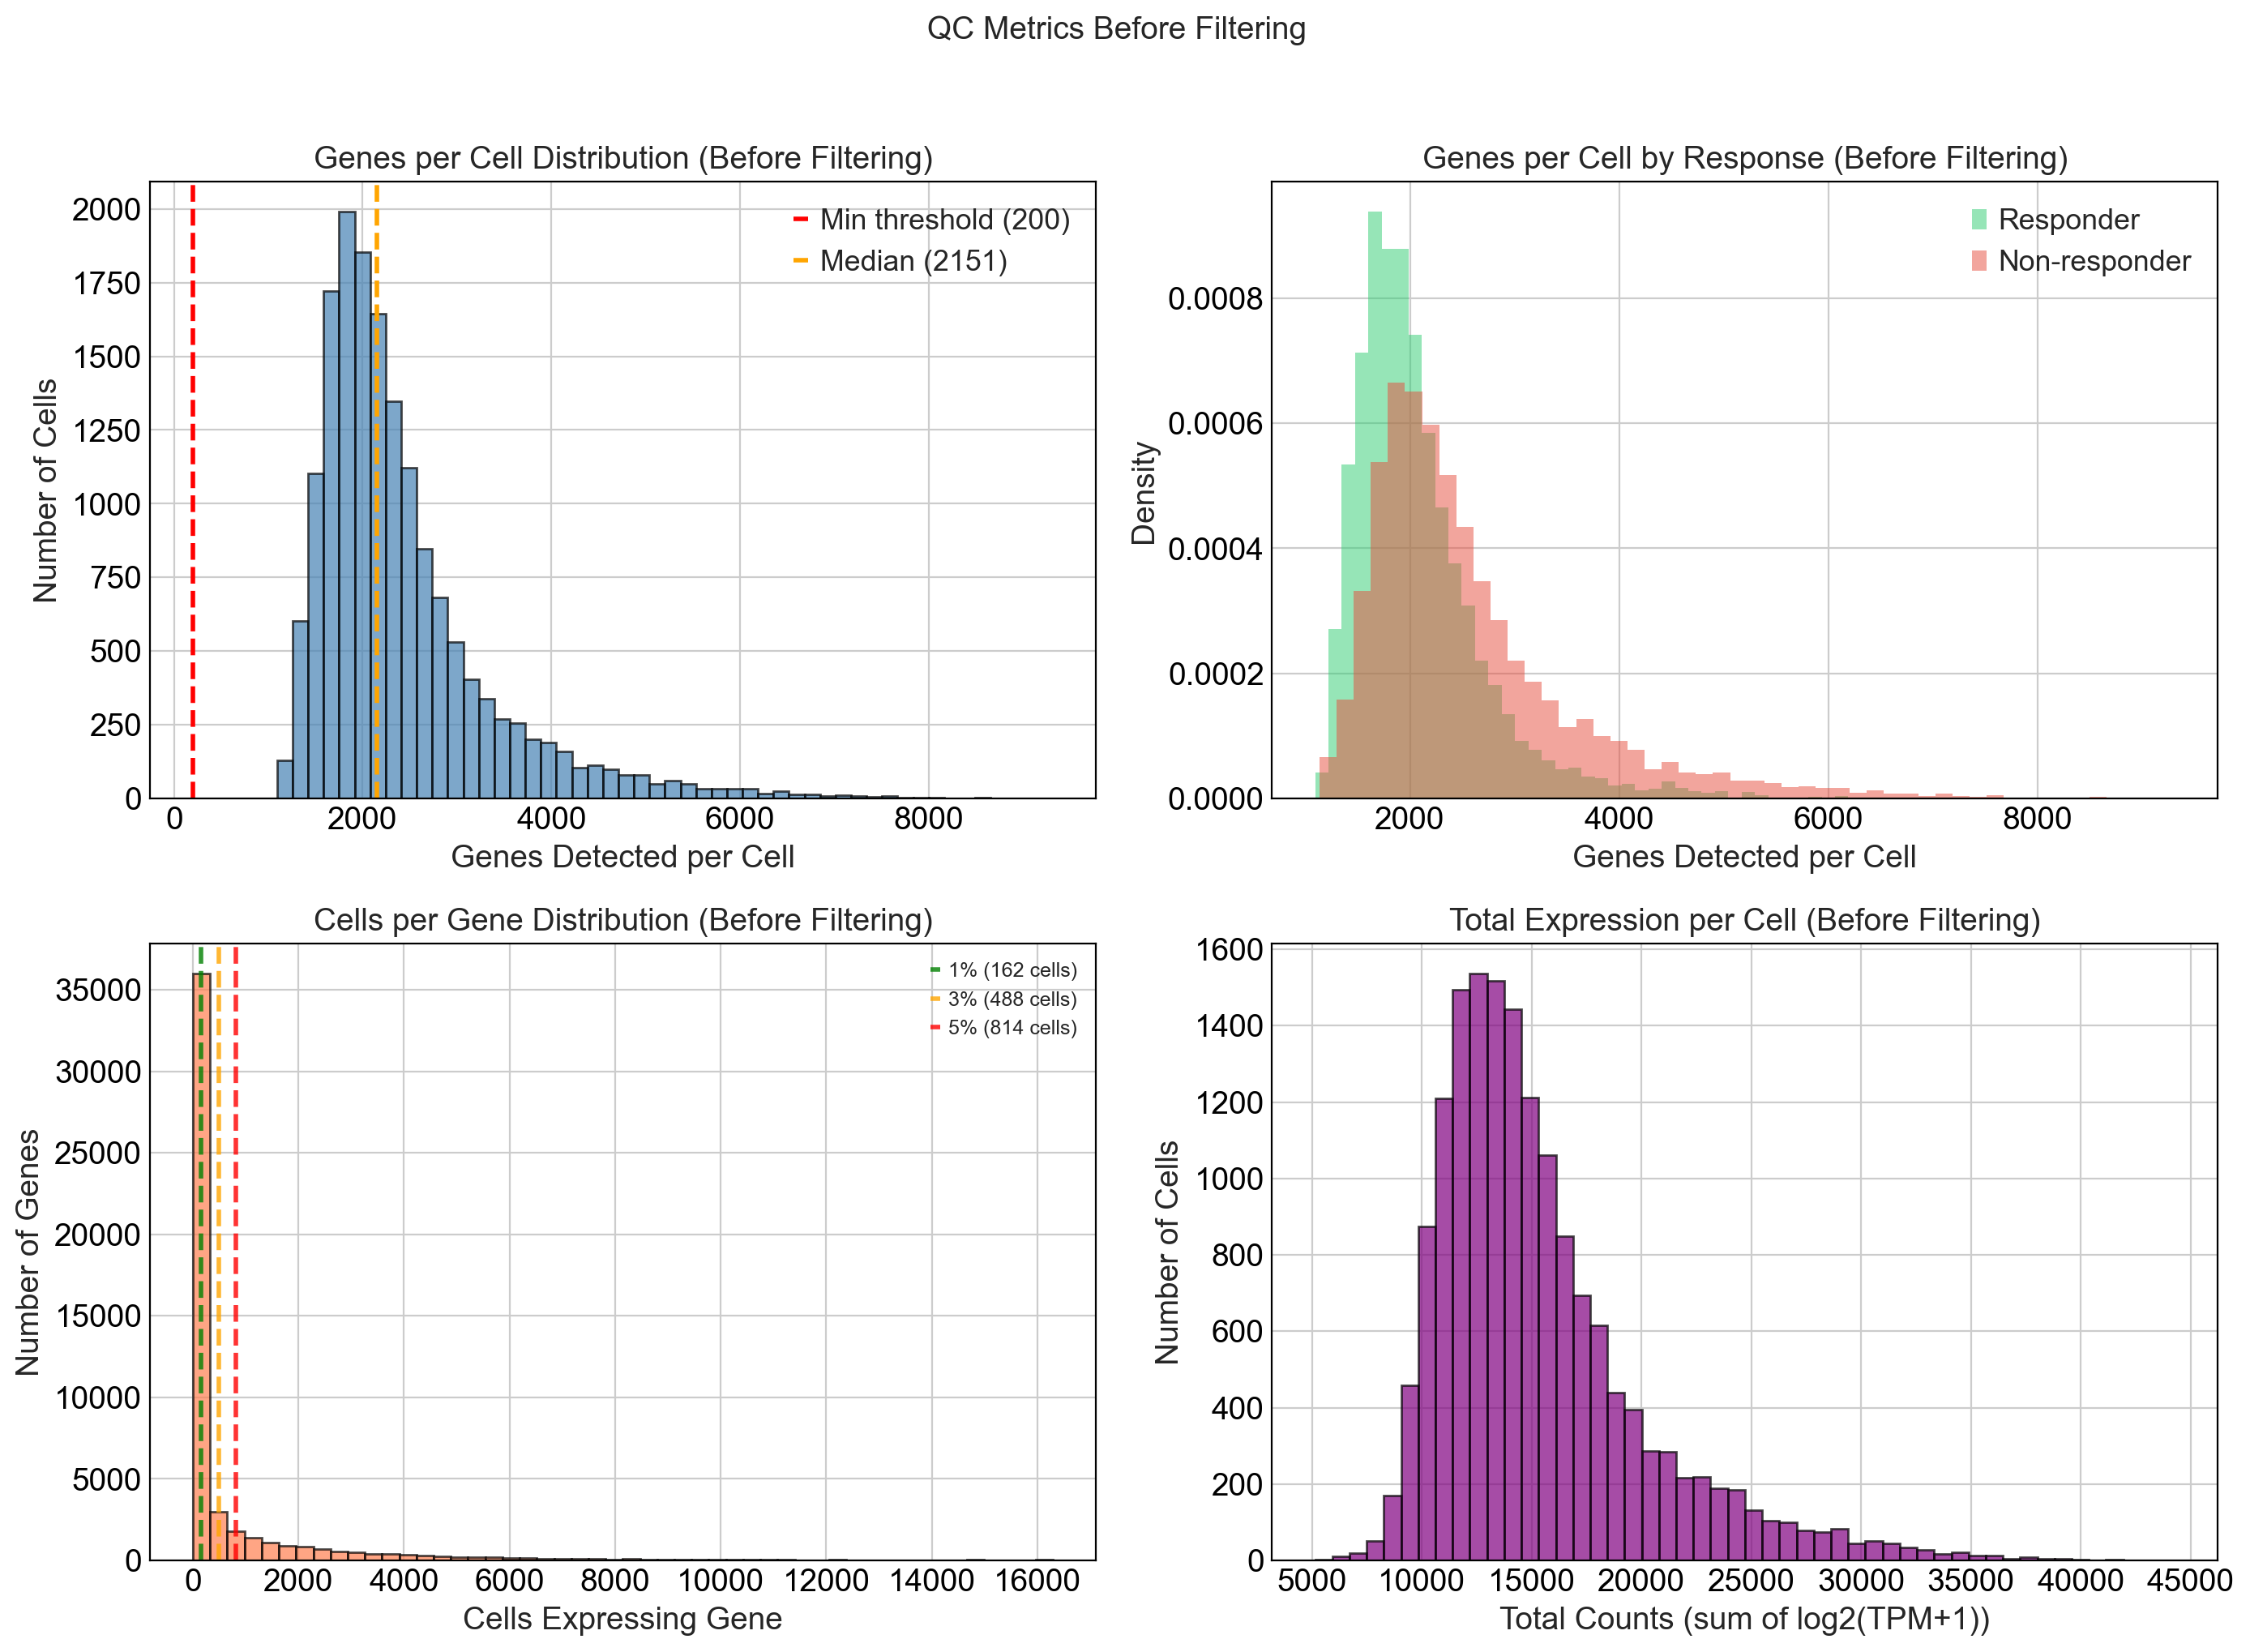

✓ Saved: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/preprocessing_qc_before.png


In [6]:
# Visualize QC metrics before filtering
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Genes per cell histogram
ax = axes[0, 0]
ax.hist(adata.obs['n_genes_detected'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(200, color='red', linestyle='--', linewidth=2, label='Min threshold (200)')
ax.axvline(adata.obs['n_genes_detected'].median(), color='orange', linestyle='--', 
           linewidth=2, label=f"Median ({adata.obs['n_genes_detected'].median():.0f})")
ax.set_xlabel('Genes Detected per Cell')
ax.set_ylabel('Number of Cells')
ax.set_title('Genes per Cell Distribution (Before Filtering)')
ax.legend()

# 2. Genes per cell by response
ax = axes[0, 1]
for response, color in [('Responder', '#2ecc71'), ('Non-responder', '#e74c3c')]:
    mask = adata.obs['response'] == response
    ax.hist(adata.obs.loc[mask, 'n_genes_detected'], bins=50, alpha=0.5, 
            color=color, label=response, density=True)
ax.set_xlabel('Genes Detected per Cell')
ax.set_ylabel('Density')
ax.set_title('Genes per Cell by Response (Before Filtering)')
ax.legend()

# 3. Cells per gene histogram (log scale)
ax = axes[1, 0]
cells_per_gene = adata.var['n_cells_expressed']
ax.hist(cells_per_gene[cells_per_gene > 0], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Cells Expressing Gene')
ax.set_ylabel('Number of Genes')
ax.set_title('Cells per Gene Distribution (Before Filtering)')

# Add vertical lines for different thresholds
n_cells = adata.n_obs
thresholds = [(0.01, '1%'), (0.03, '3%'), (0.05, '5%')]
colors = ['green', 'orange', 'red']
for (frac, label), color in zip(thresholds, colors):
    thresh = int(n_cells * frac)
    ax.axvline(thresh, color=color, linestyle='--', linewidth=2, alpha=0.8,
               label=f'{label} ({thresh} cells)')
ax.legend(fontsize=9)

# 4. Total counts per cell
ax = axes[1, 1]
ax.hist(adata.obs['total_counts'], bins=50, color='purple', edgecolor='black', alpha=0.7)
ax.set_xlabel('Total Counts (sum of log2(TPM+1))')
ax.set_ylabel('Number of Cells')
ax.set_title('Total Expression per Cell (Before Filtering)')

plt.suptitle('QC Metrics Before Filtering', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'preprocessing_qc_before.png', bbox_inches='tight')
plt.show()
print(f"✓ Saved: {FIGURES_DIR / 'preprocessing_qc_before.png'}")


---
## 3. Gene Filtering

Filter out genes that are not informative:

1. **Low-prevalence genes**: Remove genes detected in fewer than N% of cells
2. **Mitochondrial genes**: Remove MT- genes (often reflect cell stress, not biology)

**Rationale:**
- The PRECISE paper doesn't specify exact thresholds
- Standard scRNA-seq practice: keep genes in at least 1-3% of cells
- Goal: reduce from ~55k genes to ~8k-12k informative genes


In [7]:
# Explore different filtering thresholds
print("Gene Filtering Threshold Analysis")
print("=" * 60)

n_cells = adata.n_obs
cells_per_gene = (adata.X > 0).sum(axis=0)
if hasattr(cells_per_gene, 'A1'):
    cells_per_gene = cells_per_gene.A1
else:
    cells_per_gene = np.asarray(cells_per_gene).flatten()

# Test different thresholds
thresholds = [0.005, 0.01, 0.02, 0.03, 0.05, 0.10]
print(f"\nTotal cells: {n_cells:,}")
print(f"Total genes: {adata.n_vars:,}")
print(f"\nGenes retained at different prevalence thresholds:")
print("-" * 50)

threshold_results = []
for frac in thresholds:
    min_cells = int(np.ceil(n_cells * frac))
    genes_retained = (cells_per_gene >= min_cells).sum()
    pct_retained = genes_retained / adata.n_vars * 100
    threshold_results.append((frac, min_cells, genes_retained, pct_retained))
    print(f"  {frac*100:4.1f}% ({min_cells:5,} cells): {genes_retained:6,} genes ({pct_retained:5.1f}%)")

print("\n✓ Recommendation: 3% threshold (~8-12k genes)")


Gene Filtering Threshold Analysis



Total cells: 16,290
Total genes: 55,737

Genes retained at different prevalence thresholds:
--------------------------------------------------
   0.5% (   82 cells): 21,405 genes ( 38.4%)
   1.0% (  163 cells): 17,665 genes ( 31.7%)
   2.0% (  326 cells): 14,511 genes ( 26.0%)
   3.0% (  489 cells): 12,800 genes ( 23.0%)
   5.0% (  815 cells): 10,538 genes ( 18.9%)
  10.0% (1,629 cells):  7,228 genes ( 13.0%)

✓ Recommendation: 3% threshold (~8-12k genes)


In [8]:
# Apply gene filtering with 3% threshold
print("Applying Gene Filtering")
print("=" * 60)

GENE_MIN_CELLS_FRACTION = 0.03  # 3% of cells
REMOVE_MT_GENES = True

n_genes_before = adata.n_vars

adata = filter_genes(
    adata,
    min_cells_fraction=GENE_MIN_CELLS_FRACTION,
    remove_mt_genes=REMOVE_MT_GENES,
    remove_ribo_genes=False,  # Keep ribosomal genes for immune cell analysis
    verbose=True
)

n_genes_after = adata.n_vars

print(f"\n✓ Gene filtering complete")
print(f"  Removed: {n_genes_before - n_genes_after:,} genes")
print(f"  Remaining: {n_genes_after:,} genes")


Applying Gene Filtering


  Using min_cells = 489 (3.0% of 16290 cells)


  Removing 37 mitochondrial genes (MT-)


  Genes before filtering: 55,737
  Removed by prevalence (<489 cells): 42,937
  Genes after filtering: 12,785
  Retention rate: 22.9%

✓ Gene filtering complete
  Removed: 42,952 genes
  Remaining: 12,785 genes


In [9]:
# Verify 11-gene signature is preserved
SIGNATURE_GENES = [
    'GAPDH', 'CD38', 'CCR7', 'HLA-DRB5', 'STAT1',
    'GZMH', 'LGALS1', 'IFI6', 'EPSTI1', 'HLA-G', 'GBP5'
]

print("\n11-Gene Signature Check (Post Gene Filtering)")
print("=" * 60)

gene_names = set(adata.var_names)
present = [g for g in SIGNATURE_GENES if g in gene_names]
missing = [g for g in SIGNATURE_GENES if g not in gene_names]

for gene in SIGNATURE_GENES:
    status = "✓ PRESENT" if gene in gene_names else "✗ FILTERED OUT"
    print(f"  {gene}: {status}")

print(f"\nResult: {len(present)}/{len(SIGNATURE_GENES)} signature genes retained")

if missing:
    print(f"\n⚠️ WARNING: {len(missing)} signature genes were filtered out!")
    print(f"   Missing: {missing}")
else:
    print("\n✓ All signature genes preserved")



11-Gene Signature Check (Post Gene Filtering)
  GAPDH: ✓ PRESENT
  CD38: ✓ PRESENT
  CCR7: ✓ PRESENT
  HLA-DRB5: ✓ PRESENT
  STAT1: ✓ PRESENT
  GZMH: ✓ PRESENT
  LGALS1: ✓ PRESENT
  IFI6: ✓ PRESENT
  EPSTI1: ✓ PRESENT
  HLA-G: ✓ PRESENT
  GBP5: ✓ PRESENT

Result: 11/11 signature genes retained

✓ All signature genes preserved


---
## 4. Cell Filtering

Filter out low-quality cells:

- **Minimum genes**: Remove cells with fewer than 200 detected genes
  - These may be empty droplets, debris, or poor-quality cells
  
Note: The GSE120575 dataset has already been quality-filtered, so most cells should pass.


In [10]:
# Recompute QC metrics after gene filtering and apply cell filtering
adata = compute_qc_metrics(adata, verbose=False)

print("Applying Cell Filtering")
print("=" * 60)

CELL_MIN_GENES = 200
n_cells_before = adata.n_obs

adata = filter_cells(
    adata,
    min_genes=CELL_MIN_GENES,
    max_genes=None,  # No upper limit
    verbose=True
)

n_cells_after = adata.n_obs

print(f"\n✓ Cell filtering complete")
print(f"  Removed: {n_cells_before - n_cells_after:,} cells")
print(f"  Remaining: {n_cells_after:,} cells")


Applying Cell Filtering


  Cells before filtering: 16,290
  Cells removed (min_genes=200): 0
  Cells after filtering: 16,290
  Retention rate: 100.0%

✓ Cell filtering complete
  Removed: 0 cells
  Remaining: 16,290 cells


---
## 5. Normalization Check

**Important:** The GSE120575 data is **already log2(TPM+1) transformed**.

For XGBoost (tree-based models), no additional normalization is required.
We verify the data is in the expected range and document this for reproducibility.


In [11]:
# Verify normalization state and apply (keeping as-is for XGBoost)
print("Normalization Verification")
print("=" * 60)

X = adata.X
print(f"\nExpression value statistics:")
print(f"  Min: {X.min():.4f}")
print(f"  Max: {X.max():.4f}")
print(f"  Mean: {X.mean():.4f}")

# Check for log-transformation evidence
is_log_transformed = X.min() >= 0 and X.max() < 25
print(f"\nLog-transformation check:")
print(f"  Values ≥ 0: {(X.min() >= 0)}")
print(f"  Max < 25: {(X.max() < 25)}")
print(f"  Conclusion: {'Data is log2(TPM+1) transformed ✓' if is_log_transformed else 'Data may not be log-transformed ⚠️'}")

# Apply "normalization" (keeping as-is for XGBoost)
adata = normalize_expression(adata, method='none', verbose=True)
print("\n✓ No additional normalization applied (data already log2(TPM+1) - optimal for XGBoost)")


Normalization Verification

Expression value statistics:


  Min: 0.0000
  Max: 18.9600
  Mean: 1.1333

Log-transformation check:


  Values ≥ 0: True
  Max < 25: True
  Conclusion: Data is log2(TPM+1) transformed ✓


  Normalization method: none
  Input expression range: [0.00, 18.96]
  No additional normalization applied (data already log2(TPM+1))
  Output expression range: [0.00, 18.96]

✓ No additional normalization applied (data already log2(TPM+1) - optimal for XGBoost)


---
## 6. Add Binary Response Labels

Convert response labels to binary for XGBoost classification:
- Responder → 1
- Non-responder → 0


In [12]:
# Add binary response labels
print("Adding Binary Response Labels")
print("=" * 60)

adata = add_response_labels(adata, verbose=True)

# Verify labels
print("\nSample of cell metadata:")
print(adata.obs[['patient_id', 'response', 'response_binary', 'therapy']].head(10))


Adding Binary Response Labels
  Response label distribution:
    Non-responder (0): 10,726 cells
    Responder (1): 5,564 cells

Sample of cell metadata:
           patient_id   response  response_binary     therapy
A10_P3_M11     Pre_P1  Responder                1  anti-CTLA4
A11_P1_M11     Pre_P1  Responder                1  anti-CTLA4
A11_P3_M11     Pre_P1  Responder                1  anti-CTLA4
A11_P4_M11     Pre_P1  Responder                1  anti-CTLA4
A12_P3_M11     Pre_P1  Responder                1  anti-CTLA4
A12_P6_M11     Pre_P1  Responder                1  anti-CTLA4
A2_P1_M11      Pre_P1  Responder                1  anti-CTLA4
A2_P4_M11      Pre_P1  Responder                1  anti-CTLA4
A3_P1_M11      Pre_P1  Responder                1  anti-CTLA4
A3_P3_M11      Pre_P1  Responder                1  anti-CTLA4


---
## 7. Dimensionality Reduction Visualization (PCA & UMAP)

Create dimensionality reduction visualizations to:
1. Verify data quality after preprocessing
2. Explore cell clustering patterns
3. Check for batch effects or technical artifacts


In [13]:
# Identify highly variable genes and compute PCA/UMAP
print("Computing Dimensionality Reduction")
print("=" * 60)

# Identify highly variable genes for PCA
# Using 'seurat' flavor which doesn't require scikit-misc package
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
print(f"Highly variable genes identified: {adata.var['highly_variable'].sum():,}")

# Compute PCA
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
print(f"PCA completed: {adata.obsm['X_pca'].shape[1]} components")
print(f"  Variance explained (PC1-10): {adata.uns['pca']['variance_ratio'][:10].sum()*100:.1f}%")

# Compute neighbors and UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata, min_dist=0.3)
print("UMAP computation complete")


Computing Dimensionality Reduction
extracting highly variable genes


    finished (0:00:01)


Highly variable genes identified: 2,000
computing PCA


    with n_comps=50


/Users/tarekalakkadp/.pyenv/versions/3.11.9/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


    finished (0:00:02)


PCA completed: 50 components
  Variance explained (PC1-10): 16.7%
computing neighbors


    using 'X_pca' with n_pcs = 30


    finished (0:00:21)


computing UMAP


    finished (0:00:18)


UMAP computation complete


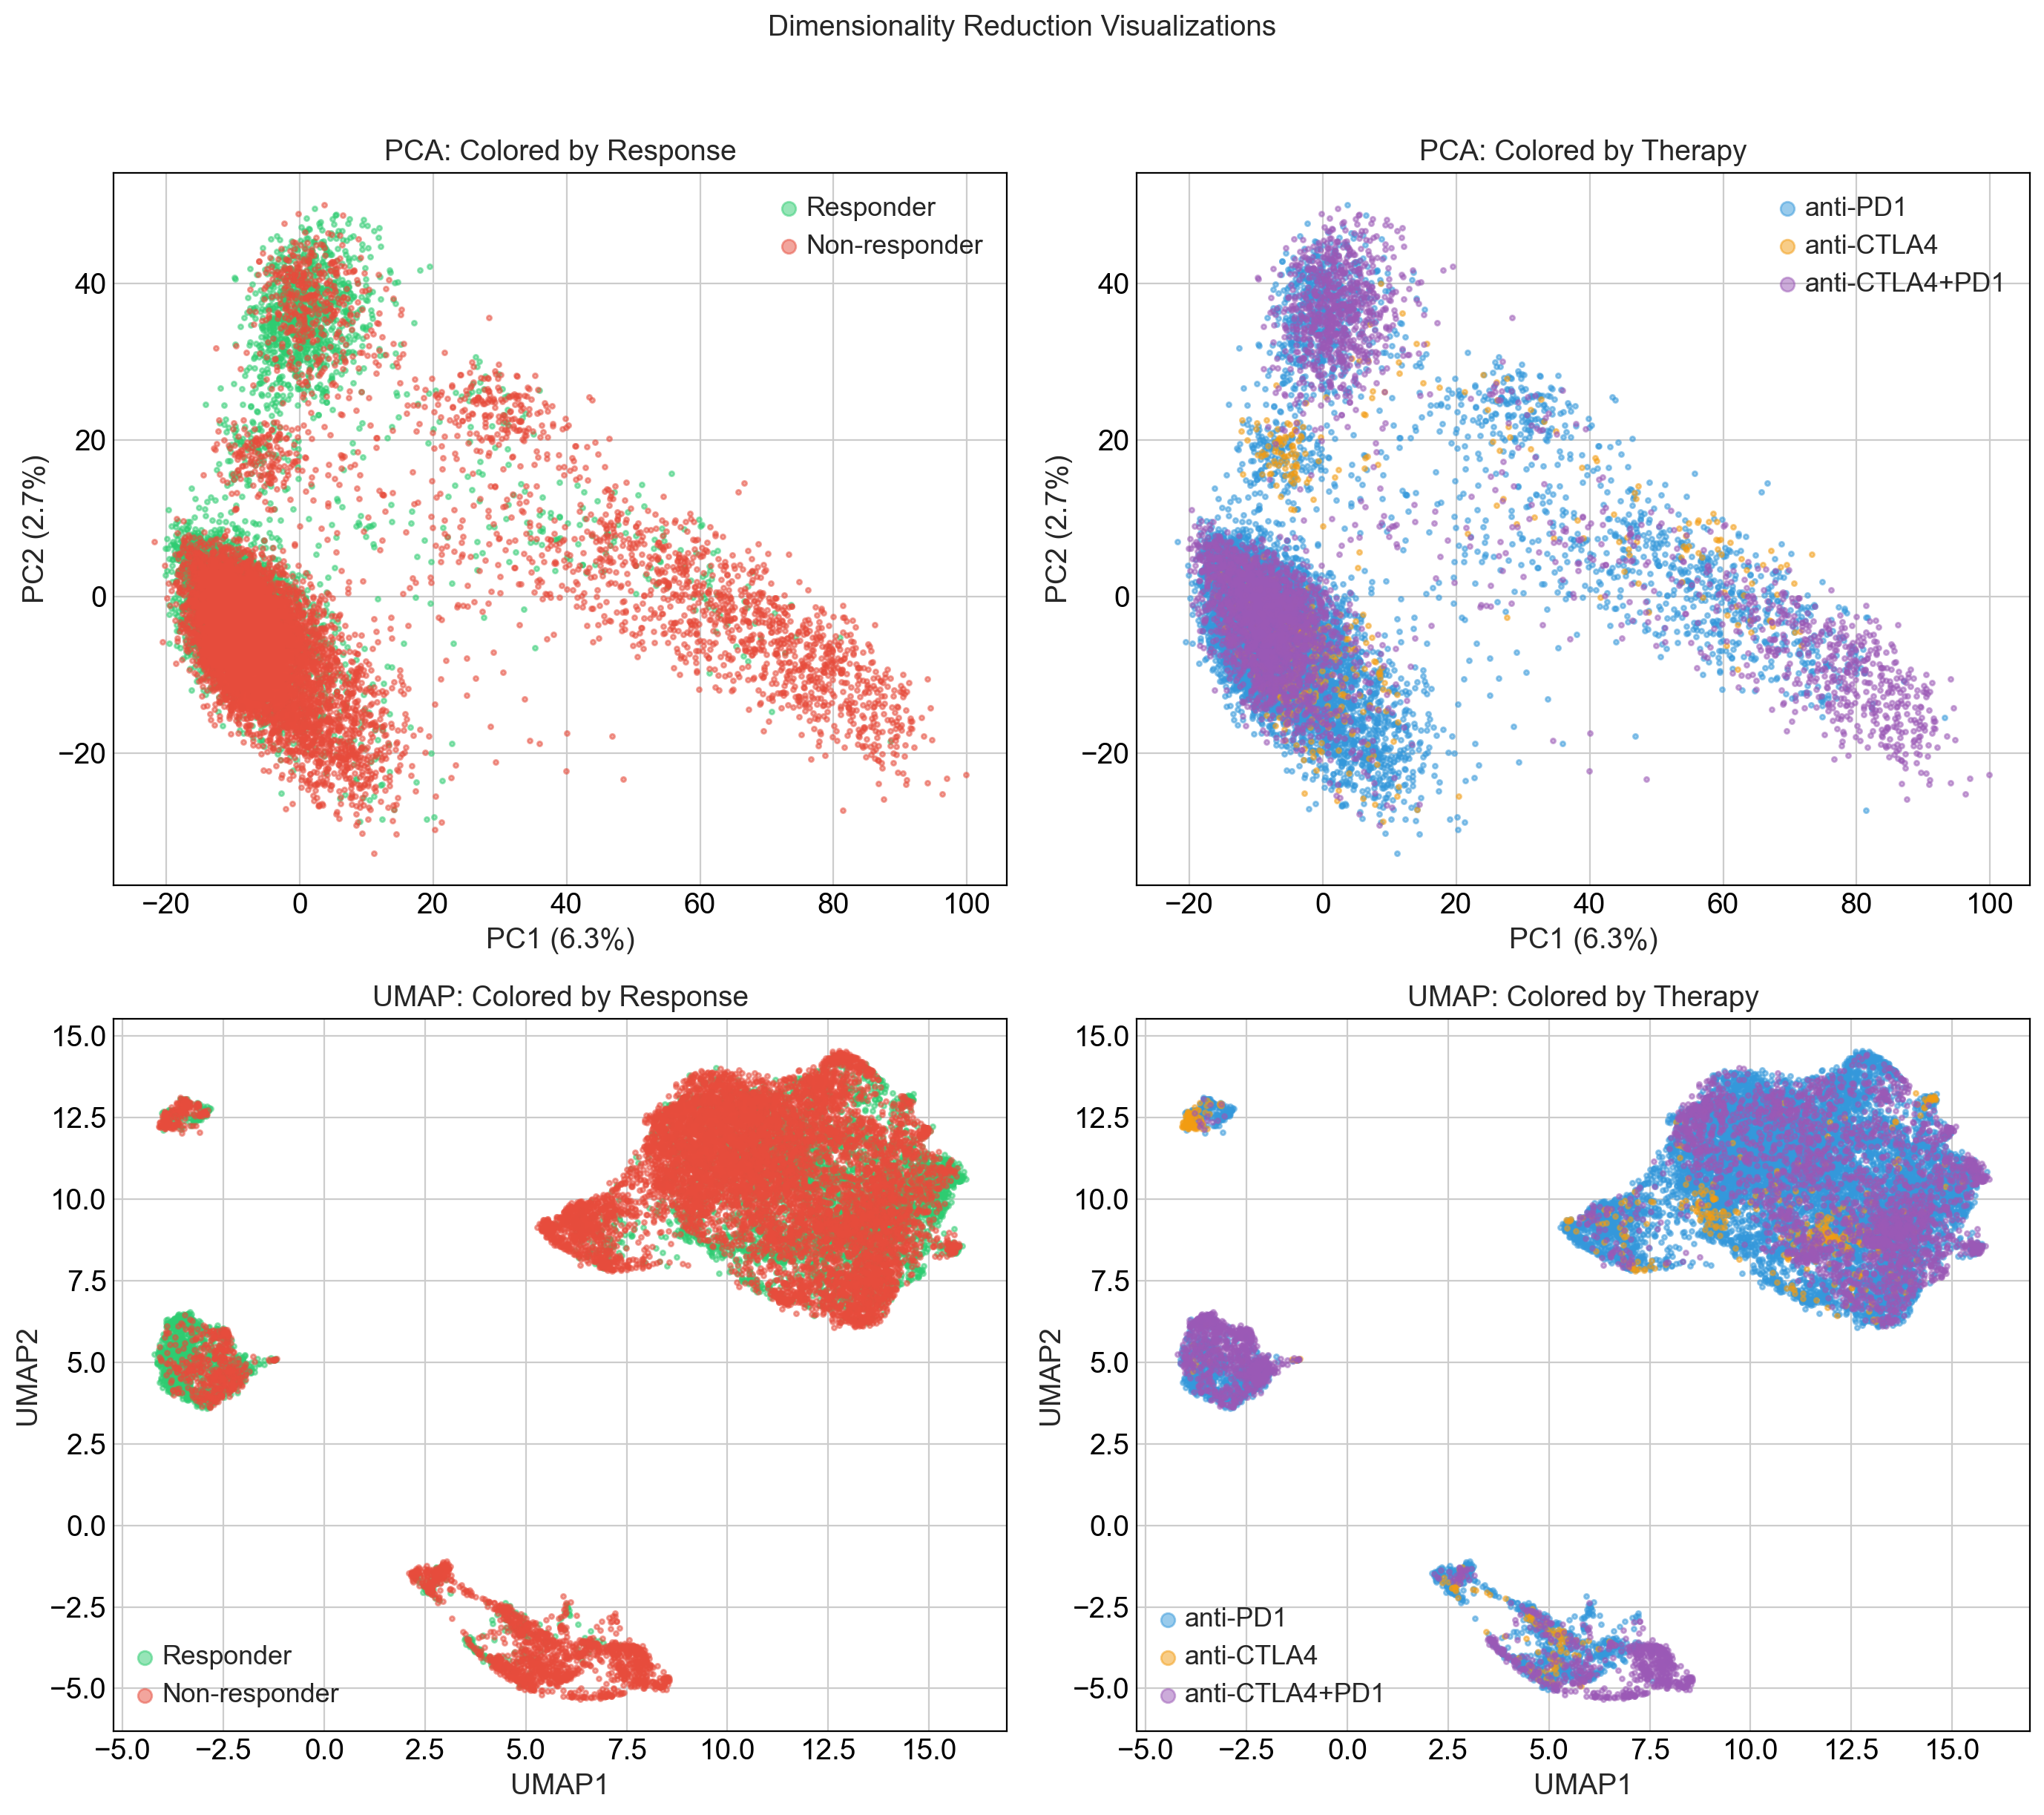

✓ Saved: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/preprocessing_dimred.png


In [14]:
# Visualize PCA and UMAP results
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

variance_ratio = adata.uns['pca']['variance_ratio']

# 1. PCA by response
ax = axes[0, 0]
for response, color in [('Responder', '#2ecc71'), ('Non-responder', '#e74c3c')]:
    mask = adata.obs['response'] == response
    ax.scatter(adata.obsm['X_pca'][mask, 0], adata.obsm['X_pca'][mask, 1],
               c=color, label=response, alpha=0.5, s=5)
ax.set_xlabel(f"PC1 ({variance_ratio[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({variance_ratio[1]*100:.1f}%)")
ax.set_title('PCA: Colored by Response')
ax.legend(markerscale=3)

# 2. PCA by therapy
ax = axes[0, 1]
therapy_colors = {'anti-PD1': '#3498db', 'anti-CTLA4': '#f39c12', 'anti-CTLA4+PD1': '#9b59b6'}
for therapy, color in therapy_colors.items():
    mask = adata.obs['therapy'] == therapy
    ax.scatter(adata.obsm['X_pca'][mask, 0], adata.obsm['X_pca'][mask, 1],
               c=color, label=therapy, alpha=0.5, s=5)
ax.set_xlabel(f"PC1 ({variance_ratio[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({variance_ratio[1]*100:.1f}%)")
ax.set_title('PCA: Colored by Therapy')
ax.legend(markerscale=3)

# 3. UMAP by response
ax = axes[1, 0]
for response, color in [('Responder', '#2ecc71'), ('Non-responder', '#e74c3c')]:
    mask = adata.obs['response'] == response
    ax.scatter(adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1],
               c=color, label=response, alpha=0.5, s=5)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('UMAP: Colored by Response')
ax.legend(markerscale=3)

# 4. UMAP by therapy
ax = axes[1, 1]
for therapy, color in therapy_colors.items():
    mask = adata.obs['therapy'] == therapy
    ax.scatter(adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1],
               c=color, label=therapy, alpha=0.5, s=5)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('UMAP: Colored by Therapy')
ax.legend(markerscale=3)

plt.suptitle('Dimensionality Reduction Visualizations', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'preprocessing_dimred.png', bbox_inches='tight')
plt.show()
print(f"✓ Saved: {FIGURES_DIR / 'preprocessing_dimred.png'}")


---
## 8. Save Preprocessed Data

Save the final preprocessed AnnData object for downstream modeling.


In [15]:
# Final data summary before saving
print("Final Preprocessed Data Summary")
print("=" * 60)
print(f"\nShape: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"\nObservation columns (adata.obs):")
for col in adata.obs.columns:
    print(f"  - {col}")
print(f"\nEmbeddings (adata.obsm):")
for key in adata.obsm.keys():
    print(f"  - {key}: shape {adata.obsm[key].shape}")
print(f"\nExpression range: [{adata.X.min():.2f}, {adata.X.max():.2f}]")

# Save preprocessed data
print("\n" + "=" * 60)
print("Saving Preprocessed Data")
print("=" * 60)
save_preprocessed_data(adata, OUTPUT_PATH, verbose=True)


Final Preprocessed Data Summary

Shape: 16,290 cells × 12,785 genes

Observation columns (adata.obs):
  - patient_id
  - response
  - therapy
  - n_genes_detected
  - total_counts
  - response_binary

Embeddings (adata.obsm):
  - X_pca: shape (16290, 50)
  - X_umap: shape (16290, 2)

Expression range: [0.00, 18.96]

Saving Preprocessed Data


Saved preprocessed data to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad
File size: 4275.3 MB


---
## 9. Acceptance Criteria Check

Verify all preprocessing requirements are met.


In [16]:
# Reload and verify saved file
adata_loaded = sc.read_h5ad(OUTPUT_PATH)

print("=" * 60)
print("ACCEPTANCE CRITERIA CHECK")
print("=" * 60)

# Check 1: Gene count in expected range (~8k-12k)
n_genes = adata_loaded.n_vars
genes_ok = 5000 <= n_genes <= 15000
print(f"\n1. Gene count: {n_genes:,}")
print(f"   Expected: ~8,000-12,000 genes after filtering")
print(f"   Status: {'✓ PASS' if genes_ok else '⚠️ NEEDS REVIEW'}")

# Check 2: Expression values are log-transformed (max < 20)
max_expr = adata_loaded.X.max()
expr_ok = max_expr < 25
print(f"\n2. Max expression value: {max_expr:.2f}")
print(f"   Expected: <25 (log2-transformed)")
print(f"   Status: {'✓ PASS' if expr_ok else '✗ FAIL'}")

# Check 3: File exists and is readable
file_exists = OUTPUT_PATH.exists()
file_ok = file_exists and adata_loaded.shape[0] > 0
file_size_mb = OUTPUT_PATH.stat().st_size / (1024 * 1024) if file_exists else 0
print(f"\n3. Output file: {OUTPUT_PATH.name}")
print(f"   Size: {file_size_mb:.1f} MB")
print(f"   Status: {'✓ PASS' if file_ok else '✗ FAIL'}")

# Check 4: Binary response labels exist
labels_ok = 'response_binary' in adata_loaded.obs.columns
print(f"\n4. Binary response labels: {'Present' if labels_ok else 'Missing'}")
print(f"   Status: {'✓ PASS' if labels_ok else '✗ FAIL'}")

# Check 5: All 48 patients retained
n_patients = adata_loaded.obs['patient_id'].nunique()
patients_ok = n_patients >= 45
print(f"\n5. Patient count: {n_patients}")
print(f"   Expected: ~48 patients")
print(f"   Status: {'✓ PASS' if patients_ok else '✗ FAIL'}")

# Check 6: 11-gene signature preserved
signature_present = sum(1 for g in SIGNATURE_GENES if g in adata_loaded.var_names)
signature_ok = signature_present == 11
print(f"\n6. 11-Gene signature: {signature_present}/11 genes present")
print(f"   Status: {'✓ PASS' if signature_ok else '✗ FAIL'}")

# Overall status
all_pass = genes_ok and expr_ok and file_ok and labels_ok and patients_ok and signature_ok
print("\n" + "=" * 60)
print(f"OVERALL: {'✓ ALL CHECKS PASSED' if all_pass else '⚠️ SOME CHECKS NEED REVIEW'}")
print("=" * 60)


ACCEPTANCE CRITERIA CHECK

1. Gene count: 12,785
   Expected: ~8,000-12,000 genes after filtering
   Status: ✓ PASS

2. Max expression value: 18.96
   Expected: <25 (log2-transformed)
   Status: ✓ PASS

3. Output file: melanoma_adata.h5ad
   Size: 4275.3 MB
   Status: ✓ PASS

4. Binary response labels: Present
   Status: ✓ PASS

5. Patient count: 48
   Expected: ~48 patients
   Status: ✓ PASS

6. 11-Gene signature: 11/11 genes present
   Status: ✓ PASS

OVERALL: ✓ ALL CHECKS PASSED


---
## Summary

**Preprocessing complete!**

The preprocessed data is now ready for:
1. XGBoost classification with leave-one-patient-out cross-validation
2. Feature selection (Boruta or similar)
3. 11-gene signature analysis

**Key outputs:**
- `data/processed/melanoma_adata.h5ad` - Preprocessed AnnData object
- `results/figures/preprocessing_*.png` - Visualization figures


In [17]:
# List all saved figures from this notebook
print("Saved Figures from Preprocessing")
print("=" * 40)
for fig_file in sorted(FIGURES_DIR.glob('preprocessing_*.png')):
    print(f"  📊 {fig_file.name}")


Saved Figures from Preprocessing
  📊 preprocessing_dimred.png
  📊 preprocessing_qc_before.png
